In [1]:
url = "/Users/test/Library/CloudStorage/GoogleDrive-p37497277p@gmail.com/.shortcut-targets-by-id/1lqeK8c0CUSIDkxldcqZblUoudXYiRrcN/medina_local_pmart_pdata"

import pandas as pd
import os
df = pd.read_parquet(os.path.join(url, "pdata_daily.parquet"))

: 

: 

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
from FactorAnalysis import FactorAnalysis
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [66]:
pct_close = pd.read_parquet("db/tw/pdata/close_pct.parquet")
pct_close_w = pct_close.resample("W-FRI").sum()
# random sampling
list_sample = np.random.randint(0, len(pct_close_w.columns), 100)
# random sampling
indexes = pct_close_w.index
tickers = pct_close_w.iloc[:, list_sample].columns
indices = indexes[52:]
forecast = np.zeros((len(indices), len(tickers)))
for index, date in enumerate(tqdm(indices, desc=f"arma model for top {ticker_len}, enumerate by da")):
    pct_train = pct_close_w.loc[indexes[index]:date]
    for i in range(ticker_len):
        series = pct_train[tickers[i]]
        if series.isna().any():
            prediction = 0
            print(tickers[i], "failed at", date)
            continue
            ###### ARIMA ma
        else:
            model = sm.tsa.arima.ARIMA(series, order=(2, 0, 0))
            model_fit = model.fit()
            prediction = model_fit.forecast().values[0]
        forecast[index, i] = prediction
factor = pd.DataFrame(forecast, columns=tickers, index=indices)


arma model for top 50, enumerate by da:  40%|███▉      | 31/78 [01:36<02:38,  3.38s/it]

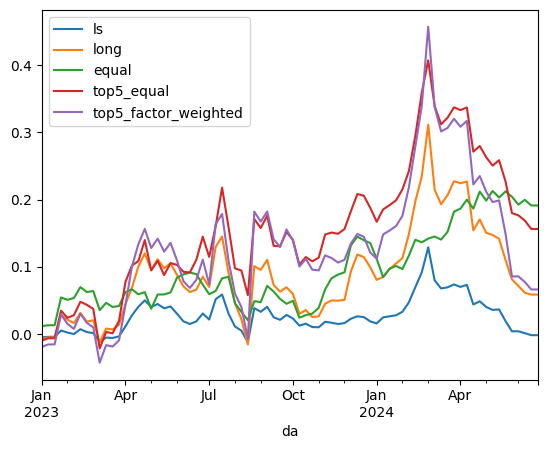

In [ ]:
fa = FactorAnalysis()
_ = fa.plot_basic(factor, top=5)

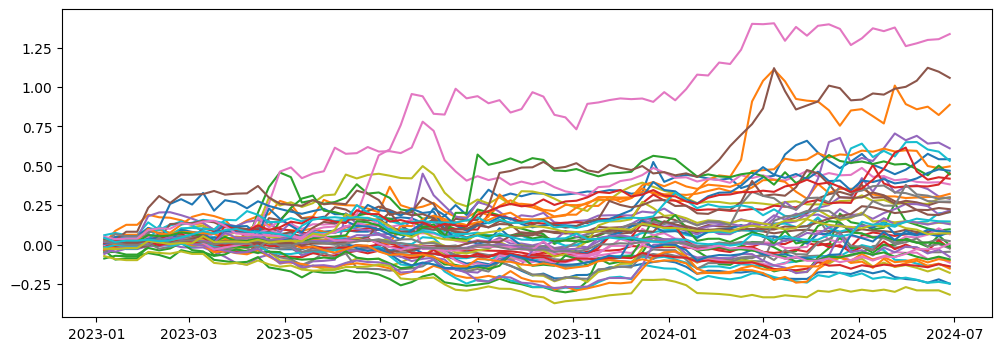

In [ ]:
all = pct_close_w[pct_close_w.columns.intersection(factor.columns)].loc['2023-01-01':]
all_cumsum = all.cumsum()
plt.figure(figsize=(12,4))
plt.plot(all_cumsum)
plt.show()

0.18626912872227191

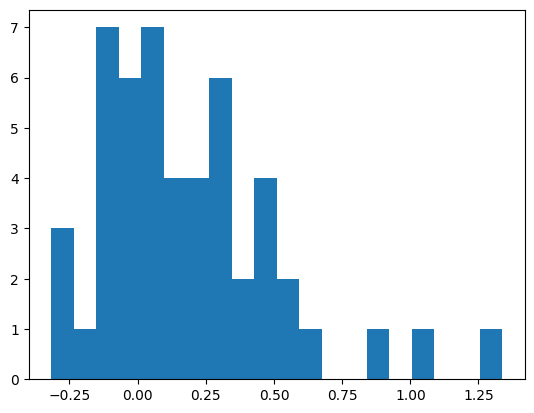

In [ ]:
all_ret = all_cumsum.iloc[-1, :]
plt.hist(all_ret, bins=20)
np.mean(all_ret)

In [ ]:
quantile = 10
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i:i+int(len(row)/quantile)])

In [ ]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    long_only_weighting = weighting[weighting > 0].fillna(0.0)*2
    return long_only_weighting

In [ ]:
pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-1)

In [ ]:
index = factor.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        
        
        # factor quantilize => weighting => * pct
    weighting = get_demean_weighting(df_1)
    
    ret = pct_close_w_corres.loc[weighting.index[0]:] * weighting
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

<Axes: xlabel='da'>

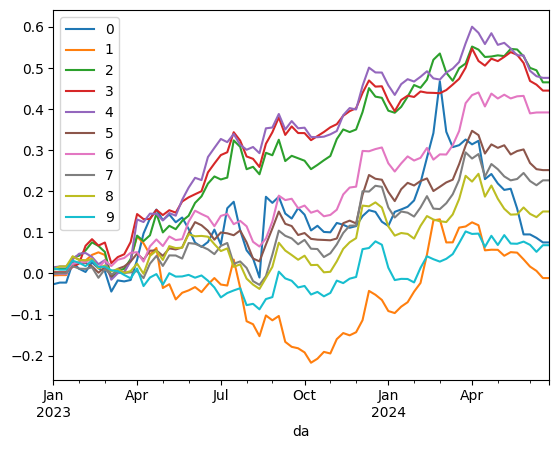

In [ ]:
quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.plot()

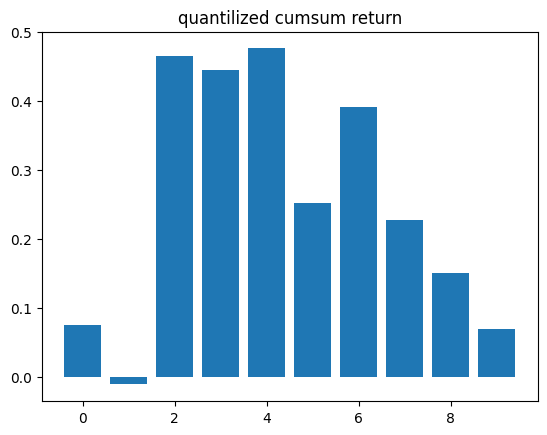

In [ ]:
plt.bar(quantilized_cumsum.columns, quantilized_cumsum.iloc[-1, :])
plt.title("quantilized cumsum return")
plt.show()